# SETUP
- - -

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Dejavu Sans"

import seaborn as sns
sns.set()

%matplotlib inline

In [112]:
!ls /Users/quartz/data/IOT_data/

ls: /Users/quartz/data/IOT_data/: No such file or directory


In [115]:
file_path = '/Users/quartz/data/iot-data/cansim-0800020-eng-6674700030567901031.csv'

In [119]:
data_raw = pd.read_csv(file_path, skiprows=6, skipfooter=9)
data_raw.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [121]:
data_raw.dtypes

Adjustments            object
Unadjusted              int64
Seasonally adjusted     int64
dtype: object

In [122]:
# 월별 끝일 삽일

from pandas.tseries.offsets import MonthEnd

# data_raw['Adjustments'] = 
data_raw.Adjustments = pd.to_datetime(data_raw['Adjustments']) + MonthEnd(1)
data_raw = data_raw.set_index('Adjustments')
data_raw.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


### Plotting

2011-01-01 00:00:00 (240, 1) (73, 1)


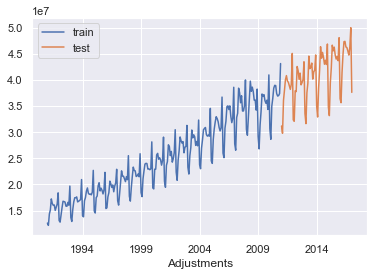

In [124]:
# 기준점 형성(Timestamp)
split_date = pd.Timestamp('01-01-2011')

# Unadjusted feature만 활용해서 dataframe을 만든다
train = data_raw.loc[:split_date, ['Unadjusted']]
test = data_raw.loc[split_date:, ['Unadjusted']]

print(split_date, train.shape, test.shape)

# plot

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

### preprocessing

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

train_sc_df = pd.DataFrame(data=train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(data=test_sc, columns=['Scaled'], index=test.index)

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [15]:
for shift in range(1, 13):
    train_sc_df['shift_{}'.format(shift)] = train_sc_df['Scaled'].shift(shift)
    test_sc_df['shift_{}'.format(shift)] = test_sc_df['Scaled'].shift(shift)

In [16]:
train_sc_df.describe()

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
count,240.000000,239.000000,238.000000,237.000000,236.000000,235.000000,234.000000,233.000000,232.000000,231.000000,230.000000,229.000000,228.000000
mean,0.420985,0.418563,0.416898,0.415272,0.413646,0.411940,0.410008,0.408054,0.406160,0.404522,0.403080,0.402519,0.401664
std,0.241028,0.238588,0.237695,0.236869,0.236042,0.235085,0.233712,0.232292,0.230983,0.230130,0.229584,0.229929,0.230070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.211260,0.210050,0.208841,0.207631,0.207044,0.206457,0.205870,0.205282,0.204648,0.204014,0.203380,0.202746,0.202611
50%,0.387050,0.383386,0.383247,0.383108,0.382566,0.382023,0.380370,0.378716,0.376887,0.375058,0.373580,0.372102,0.371540
75%,0.600857,0.599528,0.598398,0.597349,0.595715,0.593959,0.592390,0.591318,0.591266,0.590253,0.587838,0.589258,0.584998
max,1.000000,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722


### make dataset(train, test)

In [17]:
# train, test
X_train_df = train_sc_df.dropna().drop('Scaled', axis=1)
y_train_df = train_sc_df.dropna()[['Scaled']]
X_test_df = test_sc_df.dropna().drop('Scaled', axis=1)
y_test_df = test_sc_df.dropna()[['Scaled']]

# DataFrame -> ndarray
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

# check shape
X_train.shape, X_train_t.shape, X_test.shape, X_test_t.shape

### LSTM Modeling

In [ ]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 손실 이력 객체 생성
history = LossHistory() 
history.init()

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential() # Sequential Model
model.add(LSTM(100, input_shape=(12,1))) # (timestamp, feature) 
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=2, callbacks=[history])
y_pred = model.predict(X_test_t)

### Visualization

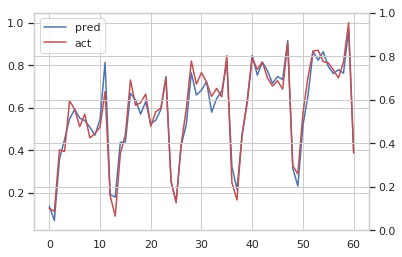

In [39]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
pred = y_pred

loss_ax.plot(pred, 'b', label='pred')
loss_ax.plot(y_test, 'r', label='act')
loss_ax.legend(loc='upper left')

plt.show()

In [40]:
len(history.losses)

300

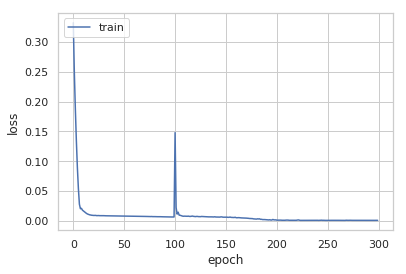

In [41]:
# loss

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 태양광 LSTM
- - -

In [3]:
!ls /Users/quartz/data/iot-data/solar_data.csv

/Users/quartz/data/iot-data/solar_data.csv


In [161]:
file_path = '/Users/quartz/data/iot-data/solar_data.csv'
solar_raw = pd.read_csv(file_path, engine='python')
solar_raw.tail()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
377,170713,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
378,170714,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
379,170715,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
380,170716,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
381,170717,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [162]:
# data shape 확인

solar_raw.shape # 1년치 시계열 데이터

(382, 84)

In [163]:
# data type 확인 - int64: 일출시간, 일몰시간, 20Hr으로 구성. float64: 

solar_raw.dtypes

날짜           int64
5Hr        float64
6Hr        float64
7Hr        float64
8Hr        float64
9Hr        float64
10Hr       float64
11Hr       float64
12Hr       float64
13Hr       float64
14Hr       float64
15Hr       float64
16Hr       float64
17Hr       float64
18Hr       float64
19Hr       float64
20Hr         int64
충전시간발전량    float64
일출시간         int64
일몰시간         int64
강수량5hr     float64
강수량6hr     float64
강수량7hr     float64
강수량8hr     float64
강수량9hr     float64
강수량10hr    float64
강수량11hr    float64
강수량12hr    float64
강수량13hr    float64
강수량14hr    float64
            ...   
풍속7hr      float64
풍속8hr      float64
풍속9hr      float64
풍속10hr     float64
풍속11hr     float64
풍속12hr     float64
풍속13hr     float64
풍속14hr     float64
풍속15hr     float64
풍속16hr     float64
풍속17hr     float64
풍속18hr     float64
풍속19hr     float64
풍속20hr     float64
기온5hr      float64
기온6hr      float64
기온7hr      float64
기온8hr      float64
기온9hr      float64
기온10hr     float64
기온11hr     float64
기온12hr     f

In [164]:
# 종속변수(충전시간발전량) 뜯어보기

solar_raw['충전시간발전량'].describe()

count     382.000000
mean     1581.694764
std       766.117874
min         0.900000
25%      1039.475000
50%      1781.700000
75%      2269.650000
max      2706.900000
Name: 충전시간발전량, dtype: float64

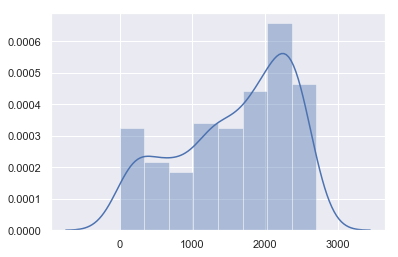

In [133]:
y = solar_raw['충전시간발전량'].values
x = list(range(382))

sns.distplot(y)

In [134]:
# 전체 feature(독립변수) 확인 : Hr, 충전시간발전량, 일출시간, 일몰시간, 강수량, 습도, 풍속, 기온

solar_raw.columns

Index(['날짜', '5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr',
       '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr', '20Hr', '충전시간발전량',
       '일출시간', '일몰시간', '강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr',
       '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr',
       '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr', '습도5hr', '습도6hr',
       '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr',
       '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr',
       '풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr',
       '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr',
       '풍속19hr', '풍속20hr', '기온5hr', '기온6hr', '기온7hr', '기온8hr', '기온9hr',
       '기온10hr', '기온11hr', '기온12hr', '기온13hr', '기온14hr', '기온15hr', '기온16hr',
       '기온17hr', '기온18hr', '기온19hr', '기온20hr'],
      dtype='object')

In [135]:
# feature 하나씩 뜯어보기

solar_raw.iloc[:1, 17:34]

,충전시간발전량,일출시간,일몰시간,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr
0,140.5,524,1949,3.2,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1


In [138]:
# 결측치 확인 : 0개

solar_raw.isna().sum()[50:100]

습도19hr    0
습도20hr    0
풍속5hr     0
풍속6hr     0
풍속7hr     0
풍속8hr     0
풍속9hr     0
풍속10hr    0
풍속11hr    0
풍속12hr    0
풍속13hr    0
풍속14hr    0
풍속15hr    0
풍속16hr    0
풍속17hr    0
풍속18hr    0
풍속19hr    0
풍속20hr    0
기온5hr     0
기온6hr     0
기온7hr     0
기온8hr     0
기온9hr     0
기온10hr    0
기온11hr    0
기온12hr    0
기온13hr    0
기온14hr    0
기온15hr    0
기온16hr    0
기온17hr    0
기온18hr    0
기온19hr    0
기온20hr    0
dtype: int64

In [139]:
solar_raw.describe()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,165853.379581,0.003141,3.643717,30.799476,88.253665,167.839005,228.170681,265.320681,280.207330,273.569372,...,14.693194,14.324869,14.090314,13.928534,13.728010,13.627749,13.514660,13.401832,13.223560,13.218325
std,4721.775092,0.034604,6.661315,34.076889,69.807035,96.133272,119.902201,132.715696,137.957655,133.337092,...,8.114350,8.172695,8.172326,8.181927,8.203442,8.239452,8.245259,8.266790,8.291745,8.382335
min,160701.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.100000,-1.600000,-1.700000,-1.600000,-1.800000,-2.200000,-2.800000,-3.600000,-4.400000,-4.600000
25%,161004.250000,0.000000,0.000000,0.000000,20.950000,82.875000,126.800000,169.850000,160.675000,174.875000,...,7.825000,7.325000,6.925000,6.650000,6.600000,6.600000,6.300000,6.125000,6.100000,5.925000
50%,170107.500000,0.000000,0.000000,14.850000,80.300000,185.950000,269.000000,306.250000,329.750000,312.100000,...,15.800000,15.400000,15.200000,15.150000,14.700000,14.650000,14.450000,14.200000,13.900000,14.250000
75%,170412.750000,0.000000,4.000000,61.175000,154.725000,251.850000,332.550000,379.650000,398.750000,387.025000,...,21.900000,21.475000,21.475000,21.299999,21.274999,21.274999,21.125001,21.025000,20.825000,20.950000
max,170717.000000,0.500000,34.900000,116.800000,233.800000,335.100000,396.100000,442.500000,460.200000,469.500000,...,29.000000,28.500000,28.200001,27.500000,27.299999,26.799999,26.900000,26.700001,26.400000,26.900000


In [165]:
solar_raw['날짜'] = solar_raw['날짜'].apply(lambda x: "20"+str(x))
solar_raw.tail()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
377,20170713,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
378,20170714,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
379,20170715,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
380,20170716,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
381,20170717,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [166]:
# 월별 끝일 삽일
solar_raw['날짜'] = pd.to_datetime(solar_raw['날짜'])
solar_raw = solar_raw.set_index('날짜')
solar_raw.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,...,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,...,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,...,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,...,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,...,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


In [167]:
solar_raw.tail()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,
2017-07-13,0.0,14.8,86.0,163.9,211.6,256.6,246.5,263.4,266.8,138.9,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
2017-07-14,0.0,0.8,38.0,108.7,200.5,322.6,366.4,348.6,262.8,199.3,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
2017-07-15,0.0,4.7,47.8,98.2,196.9,110.6,97.6,138.2,174.7,188.9,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
2017-07-16,0.0,0.0,57.0,181.8,197.7,266.0,295.2,260.1,312.1,367.8,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
2017-07-17,0.0,8.0,81.9,172.7,230.4,178.9,228.4,189.1,195.4,142.2,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [171]:
columns = list(solar_raw.columns)

2017-04-15 00:00:00 (289, 83) (94, 83)


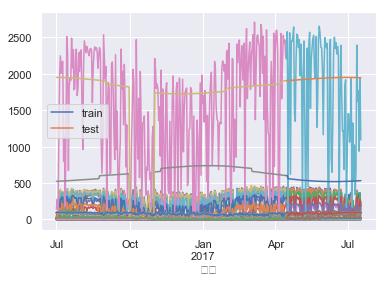

In [172]:
# 기준점 형성(Timestamp)
split_date = pd.Timestamp('2017-04-15')

# Unadjusted feature만 활용해서 dataframe을 만든다
train = solar_raw.loc[:split_date, columns]
test = solar_raw.loc[split_date:, columns]

print(split_date, train.shape, test.shape)

# plot

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [173]:
# preprocessing

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [176]:
train_sc_df = pd.DataFrame(data=train_sc, columns=columns, index=train.index)
test_sc_df = pd.DataFrame(data=test_sc, columns=columns, index=test.index)

In [ ]:
# for shift in range(1, 13):
#     train_sc_df['shift_{}'.format(shift)] = train_sc_df['Scaled'].shift(shift)
#     test_sc_df['shift_{}'.format(shift)] = test_sc_df['Scaled'].shift(shift)

In [178]:
# train, test
X_train_df = train_sc_df.dropna().drop('충전시간발전량', axis=1)
y_train_df = train_sc_df.dropna()[['충전시간발전량']]
X_test_df = test_sc_df.dropna().drop('충전시간발전량', axis=1)
y_test_df = test_sc_df.dropna()[['충전시간발전량']]

# DataFrame -> ndarray
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

In [180]:
X_train.shape

(289, 82)

In [181]:
# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.
X_train_t = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_t = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# check shape
X_train.shape, X_train_t.shape, X_test.shape, X_test_t.shape

((289, 82), (289, 82, 1), (94, 82), (94, 82, 1))

In [182]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [186]:
K.clear_session()

model = Sequential() # Sequential Model
model.add(LSTM(100, input_shape=(82,1))) # (timestamp, feature) 
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1)
y_pred = model.predict(X_test_t)

Epoch 1/100
289/289 [==============================] - 2s 7ms/step - loss: 0.2632
Epoch 2/100
289/289 [==============================] - 1s 4ms/step - loss: 0.1282
Epoch 3/100
289/289 [==============================] - 1s 3ms/step - loss: 0.1148
Epoch 4/100
289/289 [==============================] - 1s 4ms/step - loss: 0.1032
Epoch 5/100
289/289 [==============================] - 1s 3ms/step - loss: 0.0909
Epoch 6/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0846
Epoch 7/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0813
Epoch 8/100
289/289 [==============================] - 1s 3ms/step - loss: 0.0792
Epoch 9/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0792
Epoch 10/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0834
Epoch 11/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0799
Epoch 12/100
289/289 [==============================] - 1s 4ms/step - loss: 0.0782
Epoch 13/100


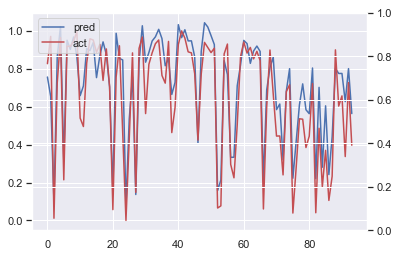

In [187]:
# visualization

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
pred = y_pred

loss_ax.plot(pred, 'b', label='pred')
loss_ax.plot(y_test, 'r', label='act')
loss_ax.legend(loc='upper left')

plt.show()

### preprocessing

```

#1

    1. 20Hr, 일몰시간, 일출시간, 날짜 : int64 -> float64


#2
```

In [64]:
from sklearn.model_selection import train_test_split

In [61]:
solar_data = solar_raw.copy()
solar_data = solar_data.astype('float32', copy=True)
solar_data.tail()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
377,170713.0,0.0,14.8,86.000000,163.899994,211.600006,256.600006,246.500000,263.399994,266.799988,...,23.299999,23.1,23.1,23.200001,23.4,24.200001,24.500000,24.400000,23.400000,25.700001
378,170714.0,0.0,0.8,38.000000,108.699997,200.500000,322.600006,366.399994,348.600006,262.799988,...,25.000000,24.6,25.1,24.200001,24.0,23.900000,24.900000,24.900000,25.299999,25.400000
379,170715.0,0.0,4.7,47.799999,98.199997,196.899994,110.599998,97.599998,138.199997,174.699997,...,24.000000,24.0,24.0,23.500000,23.4,23.200001,23.400000,23.799999,24.799999,25.000000
380,170716.0,0.0,0.0,57.000000,181.800003,197.699997,266.000000,295.200012,260.100006,312.100006,...,24.299999,24.1,23.9,24.400000,23.9,24.600000,24.600000,24.700001,24.500000,25.299999
381,170717.0,0.0,8.0,81.900002,172.699997,230.399994,178.899994,228.399994,189.100006,195.399994,...,24.200001,23.9,24.5,24.700001,25.1,24.200001,24.700001,24.900000,24.400000,24.000000


In [70]:
X_data = solar_data.drop(['충전시간발전량'], axis=1)
y_data = solar_data['충전시간발전량']
y_data.tail()

377    1625.199951
378    1764.500000
379     937.200012
380    1945.400024
381    1092.099976
Name: 충전시간발전량, dtype: float32

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((255, 83), (127, 83), (255,), (127,))

# modeling
- - -

```
1. x, y train, text dataset 만들기
2. linear regression으로 모델링(statsmodels)
3. 다중회귀
4. 다중 공선성 확인, 제거(PCA)
5. 파라미터 튜닝
```

### scikit-learn

In [89]:
from sklearn.linear_model import LinearRegression

In [87]:
LR = LinearRegression(fit_intercept=True)
model_lr_1 = LR.fit(X_train, y_train)

# 성능평가
y_pred = model_lr_1.predict(X_test)
mse = (np.square(y_pred - y_test)).mean(axis=0)
mse

2.903632e-06

In [88]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_test, y_pred)

1.0

In [93]:
# 교차 검증

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_lr_1, X_data, y_data, cv=50, scoring='r2')
scores = np.mean(scores)
scores

0.9999999999803469

### statsmodels

- 다중공선성 제거

In [96]:
import statsmodels.api as sm

model_lr_2 = sm.OLS(y_data, X_data)
result_2 = model_lr_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                충전시간발전량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.873e+13
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:13:32   Log-Likelihood:                 1996.9
No. Observations:                 382   AIC:                            -3926.
Df Residuals:                     348   BIC:                            -3792.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
날짜          5.239e-10    5.9e-09      0.089      0.929   -1.11e-08    1.21e-08
5Hr        -8.392e-05      0.002     -0.035      0.972      -0.005       0.005
6Hr        -2.384e-06   2.22e-05     -0.107      0.914    -4.6e-05    4.13e-05
7Hr        -1.073e-06   7.44e-06     -0.144      0.885   -1.57e-05    1.36e-05
8Hr         3.874e-07   3.68e-06      0.105      0.916   -6.86e-06    7.63e-06
9Hr        -7.153e-07   2.88e-06     -0.248      0.804   -6.39e-06    4.96e-06
10Hr           1.0000   2.14e-06   4.66e+05      0.000       1.000       1.000
11Hr           1.0000   2.15e-06   4.66e+05      0.000       1.000       1.000
12Hr           1.0000   1.91e-06   5.23e+05      0.000       1.000       1.000
13Hr           1.0000   1.84e-06   5.43e+05      0.000       1.000       1.000
14Hr           1.0000   2.13e-06    4.7e+05      0.000       1.000       1.000
15Hr           1.0000   2.66e-06   3.76e+05      0.000       1.000       1.000
16Hr           1.0000   3.37e-06   2.96e+05      0.000       1.000       1.000
17Hr       -1.371e-06   6.08e-06     -0.226      0.822   -1.33e-05    1.06e-05
18Hr       -2.861e-06   1.53e-05     -0.187      0.851   -3.29e-05    2.72e-05
19Hr       -9.537e-07      0.000     -0.009      0.993      -0.000       0.000
20Hr       -1.086e-16   1.55e-17     -6.996      0.000   -1.39e-16   -7.81e-17
일출시간       -2.682e-07   1.63e-06     -0.164      0.869   -3.48e-06    2.94e-06
일몰시간       -2.161e-07   5.74e-07     -0.377      0.707   -1.34e-06    9.12e-07
강수량5hr      2.861e-06   8.74e-05      0.033      0.974      -0.000       0.000
강수량6hr      4.768e-06   8.13e-05      0.059      0.953      -0.000       0.000
강수량7hr     -4.309e-05      0.000     -0.197      0.844      -0.000       0.000
강수량8hr              0      0.000          0      1.000      -0.001       0.001
강수량9hr     -1.907e-06      0.000     -0.005      0.996      -0.001       0.001
강수량10hr     3.433e-05      0.000      0.107      0.915      -0.001       0.001
강수량11hr    -4.005e-05      0.000     -0.094      0.925      -0.001       0.001
강수량12hr     2.801e-05      0.000      0.090      0.929      -0.001       0.001
강수량13hr     2.575e-05      0.001      0.047      0.962      -0.001       0.001
강수량14hr     4.005e-05      0.001      0.064      0.949      -0.001       0.001
강수량15hr    -1.383e-05      0.000     -0.034      0.973      -0.001       0.001
강수량16hr     2.956e-05      0.000      0.137      0.891      -0.000       0.000
강수량17hr    -1.335e-05      0.000     -0.043      0.966      -0.001       0.001
강수량18hr     5.531e-05      0.000      0.162      0.872      -0.001       0.001
강수량19hr    -4.196e-05      0.000     -0.126      0.900      -0.001       0.001
강수량20hr    -1.907e-05      0.000     -0.062      0.950      -0.001       0.001
습도5hr        3.04e-06   2.61e-05      0.116      0.907   -4.83e-05    5.44e-05
습도

In [102]:
formula = "충전시간발전량 ~ "
for column in list(X_data.columns):
    to_add = "scale({}) + ".format(column)
    formula += to_add
formula

'충전시간발전량 ~ scale(날짜) + scale(5Hr) + scale(6Hr) + scale(7Hr) + scale(8Hr) + scale(9Hr) + scale(10Hr) + scale(11Hr) + scale(12Hr) + scale(13Hr) + scale(14Hr) + scale(15Hr) + scale(16Hr) + scale(17Hr) + scale(18Hr) + scale(19Hr) + scale(20Hr) + scale(일출시간) + scale(일몰시간) + scale(강수량5hr) + scale(강수량6hr) + scale(강수량7hr) + scale(강수량8hr) + scale(강수량9hr) + scale(강수량10hr) + scale(강수량11hr) + scale(강수량12hr) + scale(강수량13hr) + scale(강수량14hr) + scale(강수량15hr) + scale(강수량16hr) + scale(강수량17hr) + scale(강수량18hr) + scale(강수량19hr) + scale(강수량20hr) + scale(습도5hr) + scale(습도6hr) + scale(습도7hr) + scale(습도8hr) + scale(습도9hr) + scale(습도10hr) + scale(습도11hr) + scale(습도12hr) + scale(습도13hr) + scale(습도14hr) + scale(습도15hr) + scale(습도16hr) + scale(습도17hr) + scale(습도18hr) + scale(습도19hr) + scale(습도20hr) + scale(풍속5hr) + scale(풍속6hr) + scale(풍속7hr) + scale(풍속8hr) + scale(풍속9hr) + scale(풍속10hr) + scale(풍속11hr) + scale(풍속12hr) + scale(풍속13hr) + scale(풍속14hr) + scale(풍속15hr) + scale(풍속16hr) + scale(풍속17hr) + scale(풍속1